In [1]:
import sys 
sys.path.append('../')
from dlim.model import DLIM 
from dlim.dataset import Data_model
from dlim.api import DLIM_API
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from numpy import mean
from numpy.random import choice
import pandas as pd
from tqdm import tqdm  
import matplotlib.pyplot as plt 
import numpy as np 

In [3]:
df_1 = pd.read_excel("../data/protein_inter/GSE102901_TableS1.xlsx", sheet_name=None)
# df_2 = pd.read_excel("./data/protein_inter/GSE102901_TableS4.xlsx", sheet_name=None)

tmp = df_1["Sheet2"]
df_id1 = tmp.drop_duplicates(subset=["id1"])[["id1", "s1_mean"]]
df_id2 = tmp.drop_duplicates(subset=["id2"])[["id2", "s2_mean"]]


/home/swang/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/swang/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
infile = "../data/protein_inter/tables1.csv"
df_data = pd.read_csv(infile, sep = ',', header = None)
data = Data_model(data=df_data, n_variables=2)
model_save_path = "./pretrain_models/model_protein_int.pth"

train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7), replace=False)
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
train_data = data.subset(train_id)
val_data = data.subset(val_id)


spectral gap = 0.9706485271453857, so we initialize phenotypes randomly
spectral gap = 0.9662427306175232, so we initialize phenotypes randomly
Model saved to ./pretrain_models/model_protein_int.pth


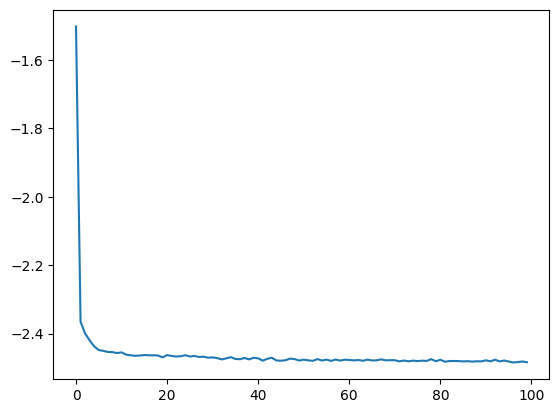

In [7]:
model = DLIM(n_variables = train_data.nb_val, hid_dim = 64, nb_layer = 1)
dlim_regressor = DLIM_API(model=model, flag_spectral=True)
losses = dlim_regressor.fit(train_data, lr = 1e-3, nb_epoch=100, batch_size=256, emb_regularization=1e-2, save_path=model_save_path)

plt.plot(losses)
plt.show()


In [ ]:
fit_v, var, _  = dlim_regressor.predict(val_data.data[:,:-1], detach=True) 
fig, (bx, cx) = plt.subplots(2, 1, figsize=(2.3, 4))
score = pearsonr(fit_v.flatten(), val_data[:, [-1]].flatten())[0]

fit, var, lat = model(data[:, :-1].int(), detach=True)
model.plot(bx, data=data, fontsize=12)

for el in ["top", "right"]:
    # ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)

# df = pd.read_excel("./data/protein_inter/GSE102901_TableS1.xlsx", sheet_name=None)
# df_id1 = df["Sheet2"].drop_duplicates(subset=["id1"])[["id1", "s1_mean"]]
# df_id2 = df["Sheet2"].drop_duplicates(subset=["id2"])[["id2", "s2_mean"]]

df_id1["s1_mean"][np.isnan(df_id1["s1_mean"])] = 0
x = [model.genes[0][data.mut_to_index[0][n]].item() for n in df_id1["id1"]]
y = [model.genes[1][data.mut_to_index[1][n]].item() for n in df_id2["id2"]]
cx.scatter(x, df_id1["s1_mean"], label="$\\varphi_1$", s=2)
cx.scatter(y, df_id2["s2_mean"], label="$\\varphi_2$", s=2)
pearsonr(y, df_id2["s2_mean"])
pearsonr(x, df_id1["s1_mean"])

cx.set_xlabel("$\\varphi$", fontsize=12)
cx.set_ylabel("PPI", fontsize=12)
cx.set_ylim([0.4, 1.1])

plt.tight_layout()
# plt.savefig("./img/lenher_2.png", dpi=300, transparent=True)
plt.show()


fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2))
x = np.linspace(min(fit_v), max(fit_v), num=100)
y = np.linspace(min(fit_v), max(fit_v), num=100)
ax.scatter(fit_v, val_data[:, [-1]].detach(), s=3, c="grey")
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score, pval = pearsonr(fit_v.flatten(), val_data[:, [-1]].flatten())
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

model.plot(bx, data=data, fontsize=12)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)

plt.tight_layout()
# plt.savefig("./img/lenher_2_fit.png", dpi=300, transparent=True)
plt.show()